<a href="https://colab.research.google.com/github/nishinomiya/markov_switching/blob/master/markov_switching_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

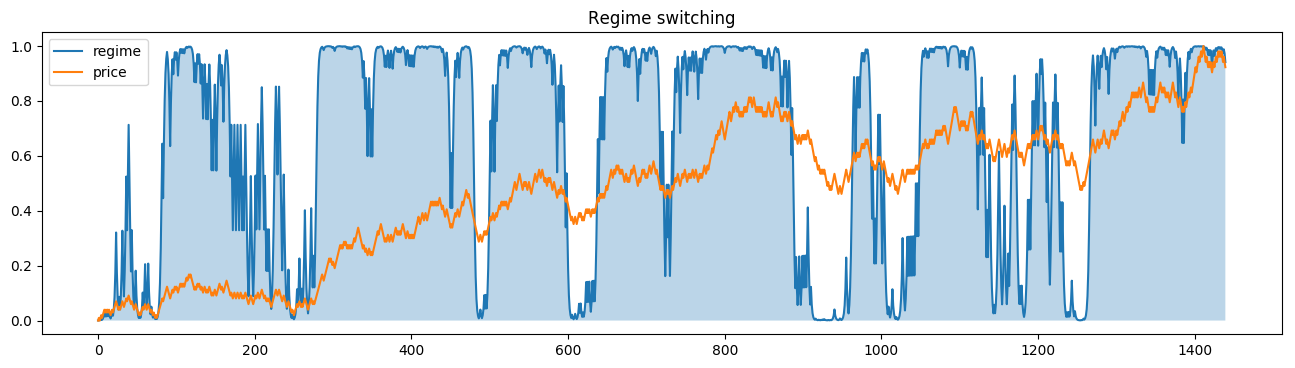

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import  pi
from decimal import *

def markov_switch(ts, p11, p22, regime1, regime2, err_std_dev, ergodic_probab=0.5):
    dec = lambda x: Decimal(str(x))
    eta = lambda y, regime, esd:  dec(1.0) / (dec(2.0) * dec(pi) * dec(esd)**dec(2.0)).sqrt() * \
                  dec(-((dec(y) - dec(regime))**dec(2.0) / (dec(2.0) * dec(esd)**dec(2.0)))).exp()

    tp1000 = dec(p11).exp() / (dec(1.0) + dec(p11).exp())
    tp0001 = dec(p22).exp() / (dec(1.0) + dec(p22).exp())
#    tp0100 = dec(1.0) - dec(tp1000) #spare for expansion
#    tp0010 = dec(1.0) - dec(tp0001) #spare for expansion
    xprobab1, xprobab2 = np.zeros_like(ts), np.zeros_like(ts)
    xprobab2[-1], xprobab2[-1] =  ergodic_probab, ergodic_probab

    for i in range(ts.shape[0]):
        eta1 = eta(ts[i], regime1, err_std_dev)
        eta2 = eta(ts[i], regime2, err_std_dev)
        bt = dec(xprobab1[i - 1]) * dec(eta1) + dec(xprobab2[i - 1]) * dec(eta2)
        xit1 = dec(xprobab1[i - 1]) * dec(eta1) / dec(bt)
        xit2 = dec(xprobab2[i - 1]) * dec(eta2) / dec(bt)
        xprobab1[i] = dec(xit1) * dec(tp1000) + dec(xit2) * (dec(1.0) - dec(tp0001))
        xprobab2[i] = dec(xit2) * dec(tp0001) + dec(xit1) * (dec(1.0) - dec(tp1000))
    return xprobab1

def normalization(x):
    x -= np.nanmin(x)
    return x / np.nanmax(x)

rc = np.random.choice([-1,1], size=1440)
ts = np.cumprod(np.exp(rc * 1e-2)) * 1.0
log_returns = np.log(ts[1:] / ts[:-1])
log_returns =  np.r_[[0.0], log_returns]

log_returns = normalization(log_returns)
f = np.percentile(log_returns, 90)
s = np.percentile(log_returns, 10)
xprobab = markov_switch(log_returns, 8, 8, f, s, np.mean(log_returns)*1.5)

nprice = normalization(ts)
plt.figure(figsize=(16, 4), dpi=100)

plt.title('Regime switching')
plt.plot(xprobab, label='regime')
plt.plot(nprice, label='price')
plt.fill_between(range(ts.shape[0]), xprobab, [0]*ts.shape[0], alpha=0.3)
plt.legend()
plt.show()